In [3]:
import pandas as pd
import numpy as np
import datetime; import pytz
import matplotlib.pyplot as plt
from joblib import dump, load
import joblib
import os
from tqdm import tqdm
from sklearn.datasets import load_svmlight_file
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from functools import reduce
import fresh.s3utils as fs3
from importlib import reload
import json
import fresh.plot as fp
import fresh.vanilla_utils as fvu
import fresh.metrics as fm

import fresh.utils as fu


In [2]:
!pip install boto3

     |████████████████████████████████| 128 kB 649 kB/s eta 0:00:01
     |████████████████████████████████| 6.3 MB 3.4 MB/s eta 0:00:01     |█████████████████▌              | 3.5 MB 1.6 MB/s eta 0:00:02     |███████████████████▍            | 3.8 MB 1.6 MB/s eta 0:00:02
     |████████████████████████████████| 69 kB 2.9 MB/s eta 0:00:01
     |████████████████████████████████| 547 kB 3.2 MB/s eta 0:00:01
     |████████████████████████████████| 126 kB 9.2 MB/s eta 0:00:01


In [4]:


os.environ['MY_SAGEMAKER_S3_BUCKET'] = ''  # storing this in my somevars.sh NOTE
os.environ['MY_ACCESS_KEY_ID'] = ''
os.environ['MY_SECRET_ACCESS_KEY'] = ''

In [5]:
# s3://my-sagemaker-blah/bikelearn/artifacts/2020-07-10T135910Z/

mybucket = os.getenv('MY_SAGEMAKER_S3_BUCKET')
s3workdir = (f's3://{mybucket}/'
            'bikelearn/artifacts/2020-07-10T135910Z/')
s3uri = (f'{s3workdir}/'
         '2020-07-16T141618Z_results_vec.json'
        )
bucket, s3fn = fs3.s3uri_to_parts(s3uri)

results_vec = json.loads(fs3.read_s3_file(bucket, s3fn))
results_vec

[{'max_depth': 3,
  'learning_rate': 0.01,
  'objective': 'multi:softprob',
  'num_class': 54,
  'base_score': 0.5,
  'booster': 'gbtree',
  'colsample_bylevel': 0.1,
  'colsample_bynode': 1,
  'colsample_bytree': 0.1,
  'gamma': 0,
  'max_delta_step': 0,
  'min_child_weight': 1,
  'random_state': 0,
  'reg_alpha': 0,
  'reg_lambda': 1,
  'scale_pos_weight': 1,
  'seed': 42,
  'subsample': 0.1,
  'verbosity': 0,
  'acc': 0.050964174262760016,
  'balanced_acc': 0.03684609209838398,
  'logloss': 3.9766314117097132,
  'walltime': 22.023615,
  'karea': 0.6426400363389939,
  'i': 0,
  'num_round': 10},
 {'max_depth': 3,
  'learning_rate': 0.01,
  'objective': 'multi:softprob',
  'num_class': 54,
  'base_score': 0.5,
  'booster': 'gbtree',
  'colsample_bylevel': 0.1,
  'colsample_bynode': 1,
  'colsample_bytree': 0.1,
  'gamma': 0,
  'max_delta_step': 0,
  'min_child_weight': 1,
  'random_state': 0,
  'reg_alpha': 0,
  'reg_lambda': 1,
  'scale_pos_weight': 1,
  'seed': 42,
  'subsample': 0.

In [6]:
df = pd.DataFrame.from_records(results_vec)

In [7]:
df.shape

(1013, 26)

In [8]:
keep_fixed = {
 'max_depth': 3,
 'learning_rate': 0.01,
 'colsample_bylevel': 0.1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.1,
 'subsample': 0.1,
 'num_round': 10,
        }
metric_cols = ['logloss','acc', 'balanced_acc', 'karea']
hyperparameters = list(keep_fixed.keys())
print(metric_cols + hyperparameters)

['logloss', 'acc', 'balanced_acc', 'karea', 'max_depth', 'learning_rate', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'subsample', 'num_round']


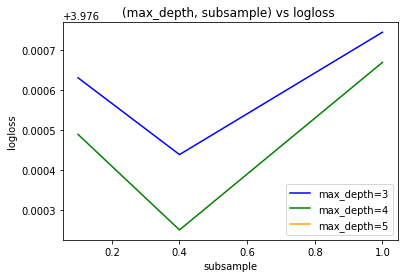

In [9]:
keep_fixed = {
# 'max_depth': 3,
 'learning_rate': 0.01,
 'colsample_bylevel': 0.1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.1,
# 'subsample': 0.1,
 'num_round': 10,
        }
#ipdb.runcall(
fp.compare_tuning(df, feature_col_1='max_depth', 
             feature_col_2='subsample', 
             metric_col='logloss',
             keep_fixed=keep_fixed)

In [13]:

print(dict(df[metric_cols + hyperparameters].sort_values(by='logloss').iloc[0]))
print(dict(df[metric_cols + hyperparameters].sort_values(by='acc').iloc[-1]))
print(dict(df[metric_cols + hyperparameters].sort_values(by='balanced_acc').iloc[-1]))

{'logloss': 3.443072437155954, 'acc': 0.12198962315156459, 'balanced_acc': 0.10436194480401938, 'karea': 0.7592264122375006, 'max_depth': 4.0, 'learning_rate': 0.1, 'colsample_bylevel': 1.0, 'colsample_bynode': 1.0, 'colsample_bytree': 1.0, 'subsample': 0.1, 'num_round': 100.0}
{'logloss': 3.4480742986458592, 'acc': 0.12304248437307332, 'balanced_acc': 0.10551953202851949, 'karea': 0.75845582462009, 'max_depth': 4.0, 'learning_rate': 0.1, 'colsample_bylevel': 1.0, 'colsample_bynode': 1.0, 'colsample_bytree': 1.0, 'subsample': 0.4, 'num_round': 100.0}
{'logloss': 3.5984655552399465, 'acc': 0.12111698141842223, 'balanced_acc': 0.1061783560314651, 'karea': 0.7373864801658441, 'max_depth': 4.0, 'learning_rate': 0.1, 'colsample_bylevel': 1.0, 'colsample_bynode': 1.0, 'colsample_bytree': 1.0, 'subsample': 0.4, 'num_round': 20.0}


In [15]:
df[['acc', 'balanced_acc', 'karea']].corr()

,acc,balanced_acc,karea
acc,1.000000,0.990795,0.946822
balanced_acc,0.990795,1.000000,0.930092
karea,0.946822,0.930092,1.000000


### 2020-07-18

#### I would like to get the train acc too to better understand the over/under (aka the overfitting/underfitting)

In [20]:
# Ingest new results file ..

s3workdir = (f's3://{mybucket}/'
            'bikelearn/artifacts/2020-07-10T135910Z')
s3uri = (f'{s3workdir}/'
         '2020-07-18T162532Z_results_vec.json'
        )
bucket, s3fn = fs3.s3uri_to_parts(s3uri)

results_vec = json.loads(fs3.read_s3_file(bucket, s3fn))
df = pd.DataFrame.from_records(results_vec)
df.shape

(1255, 26)

In [31]:
!pwd

/opt/program


In [27]:
!ls artifacts/2020-07-10T135910Z|tail -5

234_bundle_with_metrics.joblib
235_bundle_with_metrics.joblib
236_bundle_with_metrics.joblib.c44edF0B
237_bundle_with_metrics.joblib
239_bundle_with_metrics.joblib.BF0eeadc


I made a local mirror artifacts dir to grab the bundles... 

I don't really want a gigabyte of bundles though.. want to 

In [25]:
s3workdir

's3://my-sagemaker-blah/bikelearn/artifacts/2020-07-10T135910Z'

In [ ]:
# ok i ran some form of this locally... 
# aws s3 cp s3://my-sagemaker-blah/bikelearn/artifacts/2020-07-10T135910Z/ artifacts/2020-07-10T135910Z/ --recursive --include "*.joblib"

In [50]:
# As per https://github.com/namoopsoo/learn-citibike/blob/2020-revisit/notes/2020-07-10-aws.md
# the data dir was artifacts/2020-07-08T143732Z  ... going to re-create that locally too
# 
datadir = '/opt/program/artifacts/2020-07-08T143732Z'
artifactsdir = '/opt/program/artifacts/2020-07-10T135910Z'
train_results = []

train_loc = f'{datadir}/train.libsvm' 
dtrain = xgb.DMatrix(f'{train_loc}?format=libsvm')
actuals = dtrain.get_label()
print('evaluate using ', train_loc)


train_data = load_svmlight_file(train_loc)
X_train = train_data[0].toarray()
y_train = train_data[1]

[18:53:49] 316281x85 matrix with 1431544 entries loaded from /opt/program/artifacts/2020-07-08T143732Z/train.libsvm?format=libsvm
evaluate using  /opt/program/artifacts/2020-07-08T143732Z/train.libsvm


In [52]:
%%time
########
# Try one
i = 0
bundle = joblib.load(f'{artifactsdir}/{i}_bundle_with_metrics.joblib')
model = bundle['xgb_model']

y_prob_vec = model.predict(dtrain)
predictions = np.argmax(y_prob_vec, axis=1)

logloss = fu.big_logloss(actuals, y_prob=y_prob_vec, 
                         labels= list(range(54)))
acc = accuracy_score(actuals, predictions)
balanced_acc = balanced_accuracy_score(actuals, predictions)

correct_kth, karea = fm.kth_area(y_train, y_prob_vec,
        num_classes=54)

CPU times: user 31.3 s, sys: 110 ms, total: 31.4 s
Wall time: 21.4 s


In [42]:
acc, balanced_acc, karea, df.iloc[0]

(0.05276320740101365,
 0.03727538888502701,
 0.6435250908504123,
 max_depth                         3
 learning_rate                  0.01
 objective            multi:softprob
 num_class                        54
 base_score                      0.5
 booster                      gbtree
 colsample_bylevel               0.1
 colsample_bynode                  1
 colsample_bytree                0.1
 gamma                             0
 max_delta_step                    0
 min_child_weight                  1
 random_state                      0
 reg_alpha                         0
 reg_lambda                        1
 scale_pos_weight                  1
 seed                             42
 subsample                       0.1
 verbosity                         0
 acc                       0.0509642
 balanced_acc              0.0368461
 logloss                     3.97663
 walltime                    22.0236
 karea                       0.64264
 i                                 0
 num_round

In [49]:
artifactsdir = '/opt/program/artifacts/2020-07-10T135910Z'
workdir = artifactsdir 
#workdir = fu.make_work_dir(localdir); print(workdir)
fu.log(workdir, 'Going to write some logs in the "2020-07-16-local" notebook to run predictions on train  ')


In [54]:
for i in tqdm(df.i.tolist()):
    calltime = datetime.datetime.now()
    bundle_loc = f'{artifactsdir}/{i}_bundle_with_metrics.joblib'
    bundle = joblib.load(bundle_loc)
    model = bundle['xgb_model']

    y_prob_vec = model.predict(dtrain)
    predictions = np.argmax(y_prob_vec, axis=1)

    logloss = fu.big_logloss(actuals, y_prob=y_prob_vec, 
                             labels= list(range(54)))
    acc = accuracy_score(actuals, predictions)
    balanced_acc = balanced_accuracy_score(actuals, predictions)

    correct_kth, karea = fm.kth_area(y_train, y_prob_vec,
            num_classes=54)
    walltime = fu.do_walltime(calltime)
    
    res = {'train_acc': acc, 'train_balanced_acc': balanced_acc,
                         'i': i, 'train_logloss': logloss, 
                         'train_karea': karea}
    fu.log(workdir, f'[{i}] walltime {walltime}')
    train_results.append(res)
    with open(f'{workdir}/{fu.utc_ts()}_train_results_vec.json', 'w') as fd:
        json.dump({'train_results': train_results,
                  'bundle_loc': bundle_loc,
                  }, fd)
    
    
    

 16%|█▌        | 201/1255 [2:09:12<11:17:34, 38.57s/it]


KeyboardInterrupt: 

In [36]:
import xgboost as xgb
